In [111]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from pyproj import Proj, CRS, transform
import matplotlib
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from cresthh.anuga import SWW_plotter
from cresthh.anuga.utilities import sww_merge
from cresthh.anuga.shallow_water.forcing import Cross_section
from cresthh import metrics as met
%matplotlib inline
import geopandas as gpd
# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

#merge multiple files
sww_merge.sww_merge_parallel('opt_Harvey', 60, verbose=True)

In [49]:
def metrics(x,y,obj=['nse']):
    '''
    Calculate the metrics with given objective functions

    Inputs:
    ----------------
    x - observed values;
    y - simulated values

    Returns:
    -----------------
    results - list; with respect to given metrics
    '''
    if isinstance(obj, str):
        obj= list(obj)
    
    mapper= {'nse': met.nse,
            'rmse':met.rmse,
            'peak_time_error':met.peak_time_error,
            'peak_flow_error': met.peak_flow_error,
            'pearsonr': met.pearsonr,
            'bias': met.rb}

    results= []
    for single in obj:
        try:
            mask= (~np.isnan(x)) & (~np.isnan(y))
            results.append(mapper[single](x[mask],y[mask]))
        except:
            results.append(np.nan)

    return results

In [43]:
gauges= np.loadtxt('../calibration/alternative_gauges.txt', delimiter=' ')

In [3]:
sploter= SWW_plotter('opt_Harvey.sww', start_time=pd.to_datetime('20170825120000'))

Figure files for each frame will be stored in _plot


In [44]:
ilocs= []
xc= sploter.xc+ sploter.xllcorner
yc= sploter.yc+ sploter.yllcorner
for i in np.arange(len(gauges)):
    x,y= gauges[i,1],gauges[i,2]
    iloc= np.argmin( (xc-x)**2 + (yc-y)**2 )
    ilocs.append(iloc)

8076500.0 (0.8456605097032553, 0.0)


Text(0.5,1,'Gauge: 08076500')

8075900.0 (0.908288882782657, 0.0)


Text(0.5,1,'Gauge: 08075900')

8076000.0 (0.8556534625445544, 0.0)


Text(0.5,1,'Gauge: 08076000')

8076180.0 (0.9744509492825494, 0.0)


Text(0.5,1,'Gauge: 08076180')

8076700.0 (0.9641151535859183, 0.0)


Text(0.5,1,'Gauge: 08076700')

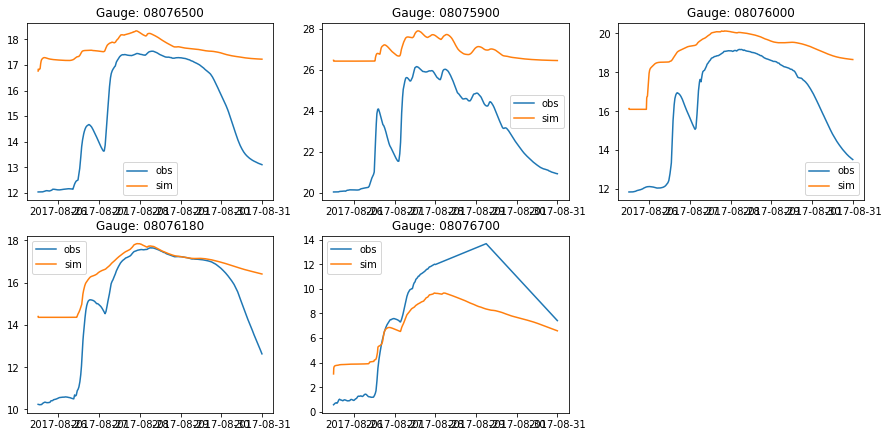

In [45]:
from scipy.stats import pearsonr

dr= pd.date_range('20170825120000','20170831000000', freq='120S')
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').stage.resample('120S',label='right').\
            interpolate().loc[dr]
    ax= fig.add_subplot(4,3,i+1)
    ax.plot(obs.index, obs,label='obs')
    ax.plot(obs.index, sploter.stage[:,ilocs[i]], label='sim')
    ax.legend();
    print gauge, pearsonr(obs, sploter.stage[:,ilocs[i]])
    ax.set_title('Gauge: %08d'%gauge);

8076500.0 [0.4998719917628929, 42.06406828513923, -19.29197011739845, Timestamp('2017-08-25 20:44:00', freq='120S'), 2.142852911681874, 0.802181213964991]
8075900.0 [0.6840289846205949, 64.69354703982822, -187.5430237857828, Timestamp('2017-08-25 11:10:00', freq='120S'), 0.006178855911005626, 0.938838997720856]
8076000.0 [0.7295914828011795, 126.86886804831522, 240.41761080855923, Timestamp('2017-08-25 22:18:00', freq='120S'), -0.36779225298703694, 0.9632658391497638]
8076180.0 [0.1544969923764561, 182.65599785590328, 365.7482456092116, Timestamp('2017-08-25 20:20:00', freq='120S'), -0.6484052204035959, 0.898831894919007]
8076700.0 [0.8279614299220946, 198.07826649537782, 154.59851768731824, Timestamp('2017-08-25 19:44:00', freq='120S'), -0.21498525376265157, 0.9439317990721117]


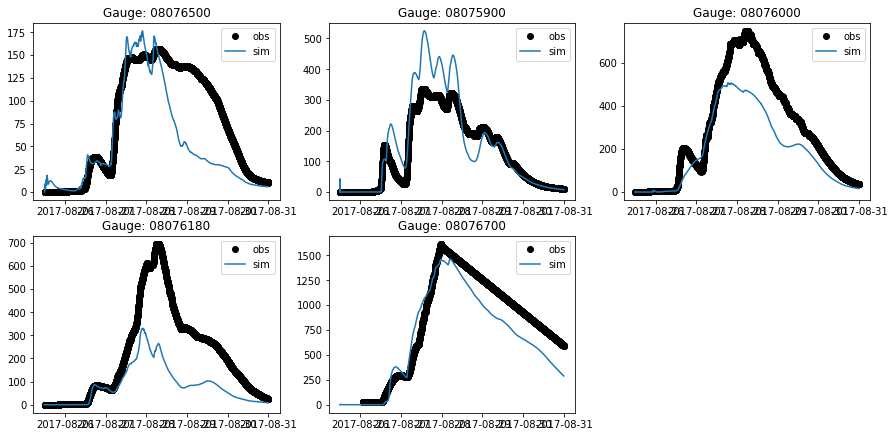

In [126]:
from scipy.stats import pearsonr

dr= pd.date_range('20170825120000','20170831000000', freq='120S')
#plot stage
fig=plt.figure(figsize=(15,15))
for i in np.arange(len(gauges)):
    gauge= gauges[i,0]
    obs_Q= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/%08d.csv'%gauge, converters={'datetime':pd.to_datetime}).set_index('datetime').discharge.resample('120S',label='right').\
            interpolate().loc[dr]
    sim= sploter.stage[:,ilocs[i]]
    crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection_new/%08d.shp'%gauge)
    area=np.array([flow_area(samples=crosssection, stage=stage) for stage in sim])
    sim_Q= sploter.speed[:,ilocs[i]] * area
    ax= fig.add_subplot(4,3,i+1)
    ax.plot(obs.index, obs_Q, 'ko',label='obs')
    ax.plot(obs.index, sim_Q, label='sim')
    ax.legend();
    print gauge, metrics(obs_Q, sim_Q, ['nse','rmse','peak_flow_error', 'peak_time_error','bias','pearsonr'])
    ax.set_title('Gauge: %08d'%gauge);
plt.show();

In [127]:
samples=gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection_new/08076180.shp')

In [128]:
elev= samples.Value
spacing= samples.distance(samples.shift()).iloc[1]
stage= sploter.stage[:,ilocs[-2]].max()

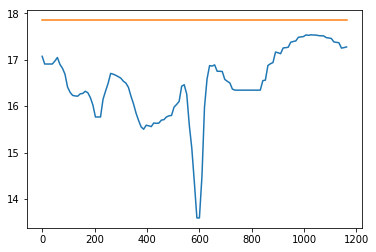

In [130]:
plt.plot(samples.distance(samples.geometry[0]), samples.Value)
plt.plot(samples.distance(samples.geometry[0]), [stage]* 121)

In [110]:
((stage-samples.Value[mask])*spacing).sum()

312.15139583092406

In [62]:
mask= np.where(elev<stage)[0]
area= ((stage-elev[mask]) * spacing).sum()

10.39237868862126

In [65]:
stages= sploter.stage[:,ilocs[-2]]

In [101]:
for i,stage in enumerate(stages):
    mask= np.where(elev<stage)[0]
    area= ((stage-elev[mask]) * spacing).sum()
    discharge= area*sploter.speed[i,ilocs[-2]]
    if i==1750:
        print area, discharge

312.15139583092406 63.71713217114807


In [52]:
coupled= processSWW('Harvey_coupled_refined_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


<Figure size 1080x576 with 0 Axes>

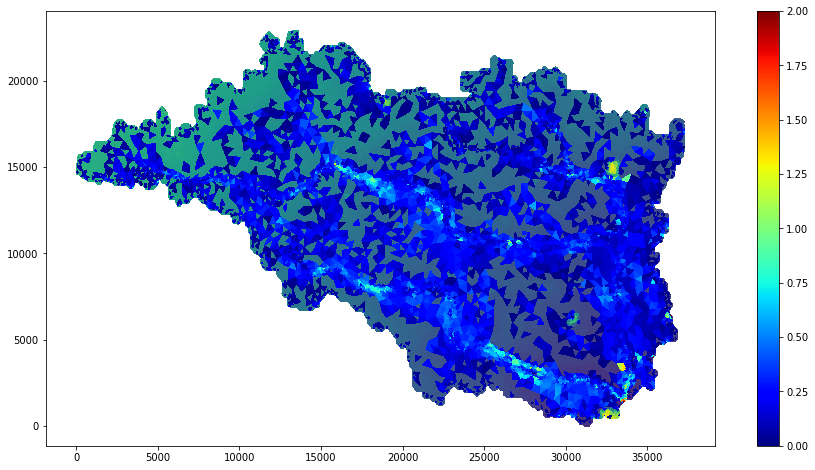

In [5]:
plt.figure(figsize=(15,8))
sploter.triang.set_mask(sploter.depth.max(axis=0) > 0.1)
plt.tripcolor(sploter.triang,
              facecolors=sploter.elev,
              cmap='viridis')
sploter.triang.set_mask(sploter.depth.max(axis=0) <= 0.1)
plt.tripcolor(sploter.triang, 
              facecolors=(sploter.speed).max(axis=0),
              cmap='jet',
             vmin=0,
             vmax=2)
plt.colorbar()

<Figure size 1080x576 with 0 Axes>

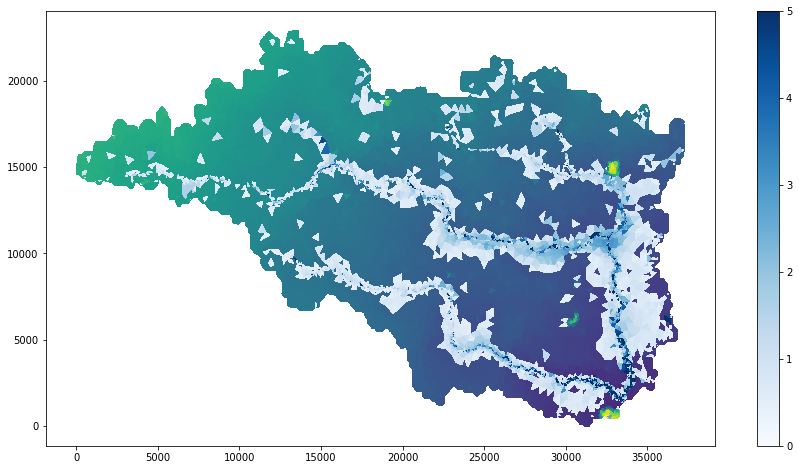

In [131]:
plt.figure(figsize=(15,8))
sploter.triang.set_mask(sploter.depth.max(axis=0) > 0.5)
plt.tripcolor(sploter.triang,
              facecolors=sploter.elev,
              cmap='viridis')
sploter.triang.set_mask(sploter.depth.max(axis=0) <= 0.5)
plt.tripcolor(sploter.triang, 
              facecolors=(sploter.depth).max(axis=0),
              cmap='Blues',
             vmin=0,
             vmax=5)
plt.colorbar()

In [154]:
from cresthh.anuga.file.netcdf import NetCDFFile
nc= NetCDFFile('opt_Harvey.sww')

In [158]:
nc.dimensions['number_of_points'].size

26526

In [ ]:
from cresthh.anuga.file_conversion.sww2dem_new import sww2dem

sww2dem('opt_Harvey.sww','max_depth.asc', quantity='depth', verbose=True, reduction=max)

Reading from opt_Harvey.sww
Output directory is max_depth.asc
------------------------------------------------
Statistics of SWW file:
  Name: opt_Harvey.sww
  Reference:
    Lower left corner: [250757.348812, 3301330.019378]
    Start time: 0.000000
  Extent:
    x [m] in [0.000000, 37293.972656], len(x) == 26526
    y [m] in [0.000000, 22885.353516], len(y) == 26526
    t [s] in [0.000000, 475200.000000], len(t) == 3961
  Quantities [SI units]:
number of points: <type 'netCDF4._netCDF4.Dimension'>: name = 'number_of_points', size = 26526
Slicing sww file, num points: <type 'netCDF4._netCDF4.Dimension'>: name = 'number_of_points', size = 26526, block size: 10000


In [24]:
dr= pd.date_range('20170825120000', '20170831000000', freq='120S')

In [9]:
coupled= processSWW('opt_Harvey.sww',['stage','depth','speed'],(284219.573  , 3302832.615),start_time=pd.to_datetime('20170825120000'))

Figure files for each frame will be stored in _plot


In [11]:
crossSection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/08076700.shp')
coupled['area']= coupled.apply(lambda x: flow_area(crossSection, x.stage), axis=1)

In [12]:
coupled['Q']= coupled.area * coupled.speed

In [35]:
obs= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08076700.csv',converters={'datetime':pd.to_datetime}).set_index('datetime')

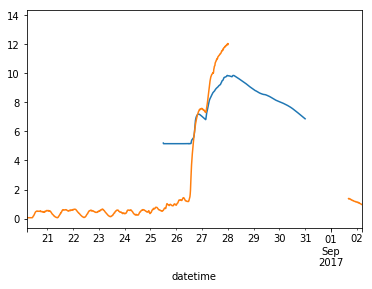

In [41]:
coupled.stage.plot()
obs.stage.plot()

,discharge,stage
datetime,,
2017-08-20 05:00:00,NaN,0.079248
2017-08-20 05:15:00,NaN,0.057912
2017-08-20 05:30:00,NaN,0.057912
2017-08-20 05:45:00,NaN,0.057912
2017-08-20 06:00:00,NaN,0.057912
2017-08-20 06:15:00,NaN,0.057912
2017-08-20 06:30:00,NaN,0.057912
2017-08-20 06:45:00,NaN,0.057912
2017-08-20 07:00:00,NaN,0.057912


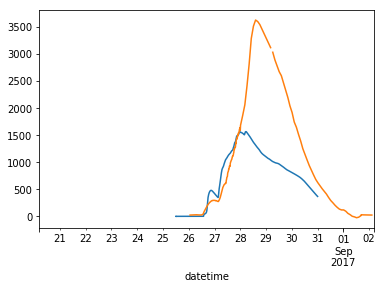

In [37]:
coupled.Q.plot()
obs.discharge.plot()

In [44]:
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
xc= sploter.xc+ sploter.xllcorner
yc= sploter.yc+ sploter.yllcorner
# initialize water depth
origin= (-95.43666, 30.11085)
origin_utm= myProj(origin[0],origin[1])
iloc= np.argmin( (xc-origin_utm[0])**2 + (yc-origin_utm[1])**2 )
# second= (-95.646063,30.11935)
# second_utm= myProj(second[0],second[1])
# dist= ((origin_utm[0]-second_utm[0])**2+ (origin_utm[1]-second_utm[1])**2)

In [15]:
period= pd.date_range('20170825','20170831', freq='120S')

In [25]:

# OBS= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08075110.txt', delimiter='\t',
#                  names=['USGS','ID','date','TZ','Q',' ','H',' '], converters={'date':pd.to_datetime}).set_index('date')
# OBS.index= OBS.index.tz_localize('US/Central').tz_convert('UTC').tz_localize(None)
# obs= OBS.resample('120S', label='right').mean().interpolate()
# # stage= sploter.stage[:,iloc]
OBS= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08075110.csv')
OBS.datetime= pd.to_datetime(OBS.datetime)
OBS.set_index('datetime', inplace=True)
# obs= OBS.resample('120S', label='right').mean().interpolate().loc[period]

In [47]:
coupled['obs']= OBS

In [48]:
coupled.obs= coupled.obs.interpolate()

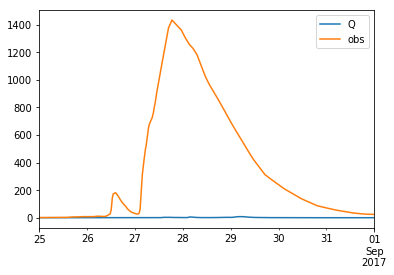

In [49]:
coupled[['Q','obs']].plot()

In [14]:
period= pd.date_range('20170825', '20170901', freq='120S')

In [12]:
len(stage)

5041

In [15]:
len(period)

5041

In [18]:
df= pd.DataFrame(index= period)
df['sim']= sploter.stage[:,iloc]
df['obs']= obs.loc[period].H*0.306

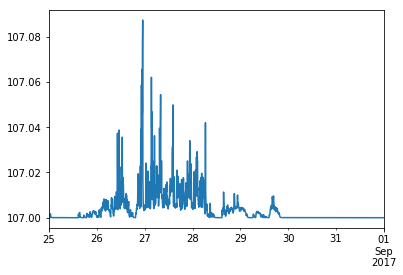

In [21]:
df.sim.plot()